In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

import sys
import torch
from data import datasets
from training import trainer
from modules import ind_generator

import datetime
import plots, utilities
from IPython.display import Image, display, Markdown
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw

from rdkit.Chem import AllChem
import py3Dmol

Preprocessing


Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.0
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Lets begin by loading the dataset

The CharSMILESChEMBLIndications dataset contains smiles strings associated with their drug indications (i.e. what diseases or conditions they are able to treat)

In [3]:

dataset = datasets.CharSMILESChEMBLIndications(
    batch_size=128
)

## What are some of the most common indications in our dataset

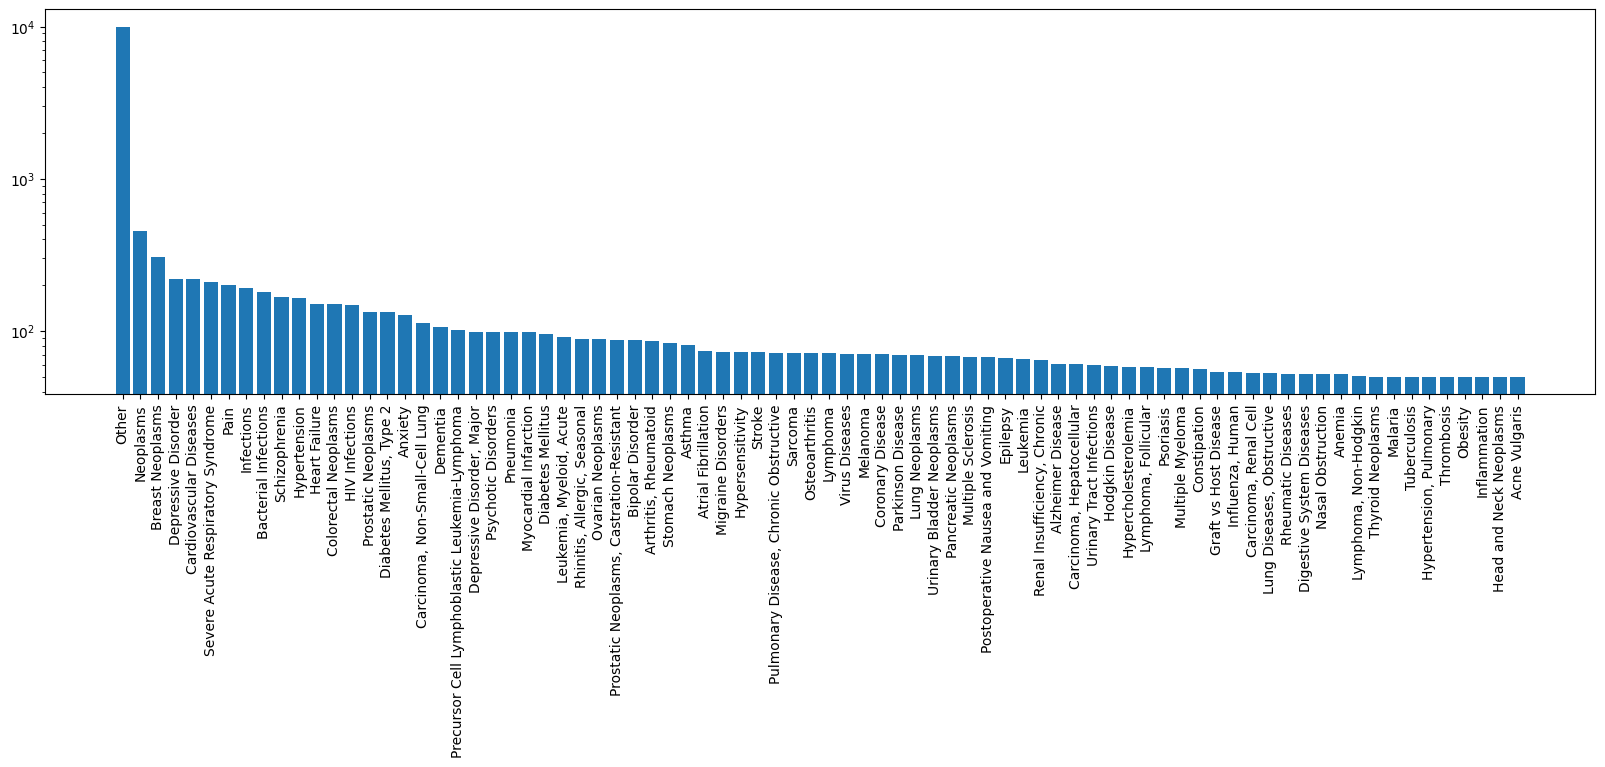

In [4]:
most_frequent_indications = dataset.all_data.drop(columns=["canonical_smiles"]).sum(axis=0).sort_values(ascending=False)
most_frequent_indications_names = most_frequent_indications.index.to_list()
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 5))
ax.bar(np.arange(len(most_frequent_indications)), most_frequent_indications.to_numpy())
ax.set_xticks(np.arange(len(most_frequent_indications)))
labels = ax.set_xticklabels([heading.replace("mesh_heading_", "") for heading in most_frequent_indications.index], rotation=90)
ax.set_yscale("log")

## What do the molecules look like for our most common indication?

## Showing 9 example chemical structures for mesh_heading_Other

rows=3, cols=3


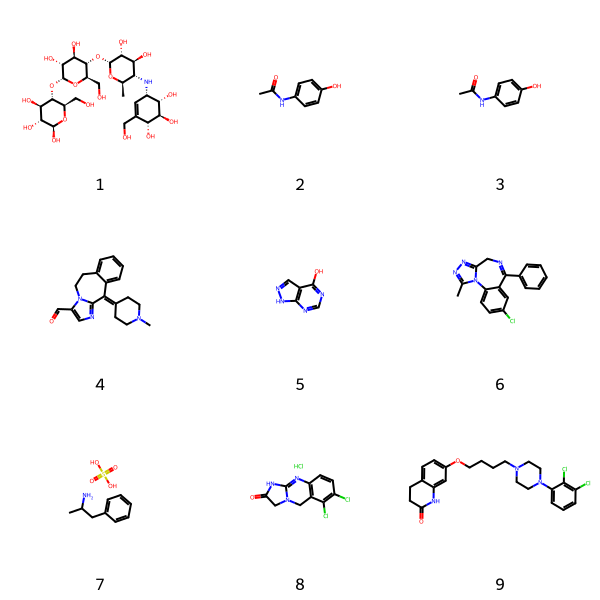

## Showing 9 example chemical structures for mesh_heading_Neoplasms

rows=3, cols=3


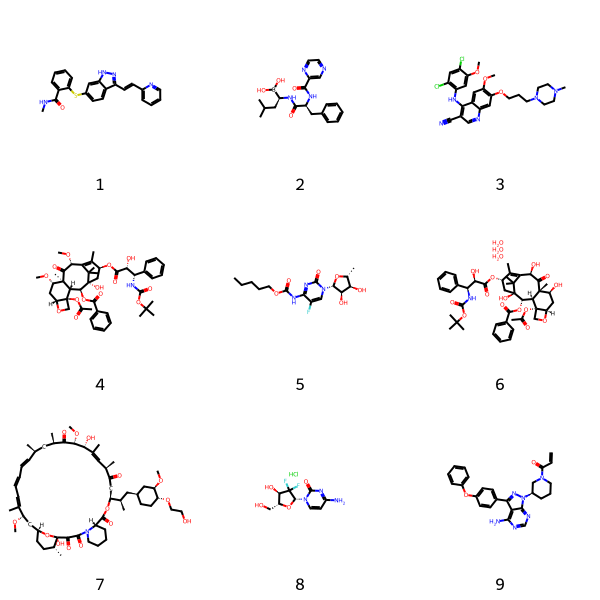

## Showing 9 example chemical structures for mesh_heading_Breast Neoplasms

rows=3, cols=3


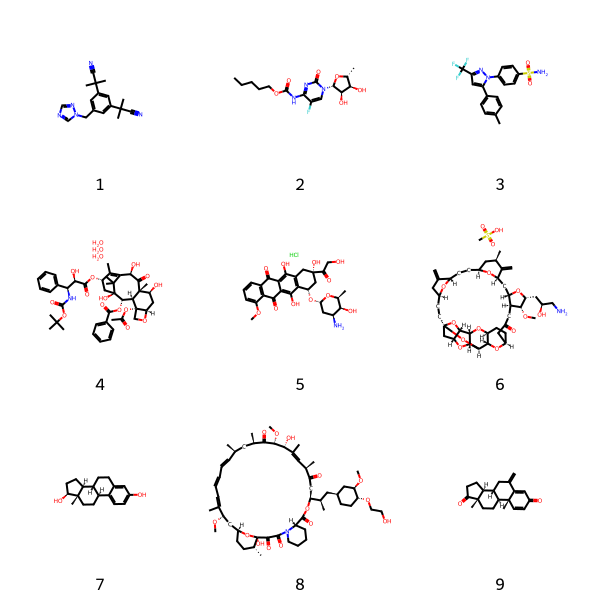

## Showing 9 example chemical structures for mesh_heading_Depressive Disorder

rows=3, cols=3


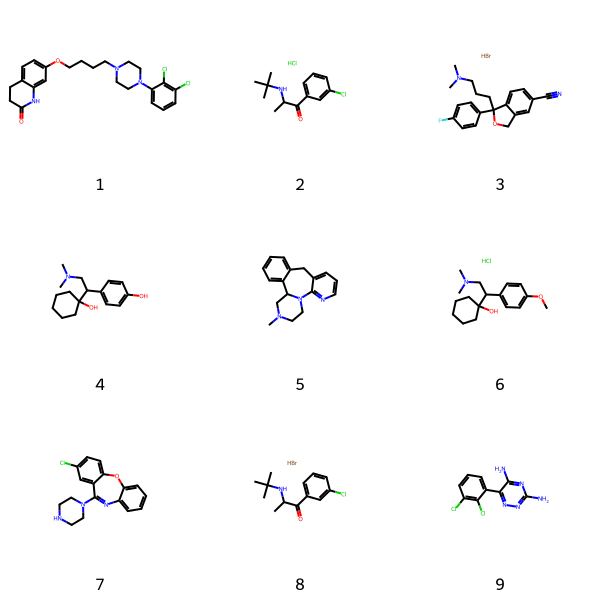

## Showing 9 example chemical structures for mesh_heading_Cardiovascular Diseases

rows=3, cols=3


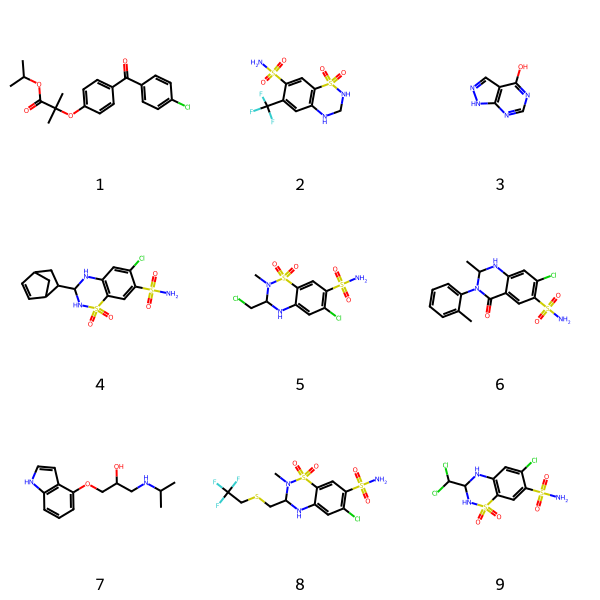

## Showing 9 example chemical structures for mesh_heading_Severe Acute Respiratory Syndrome

rows=3, cols=3


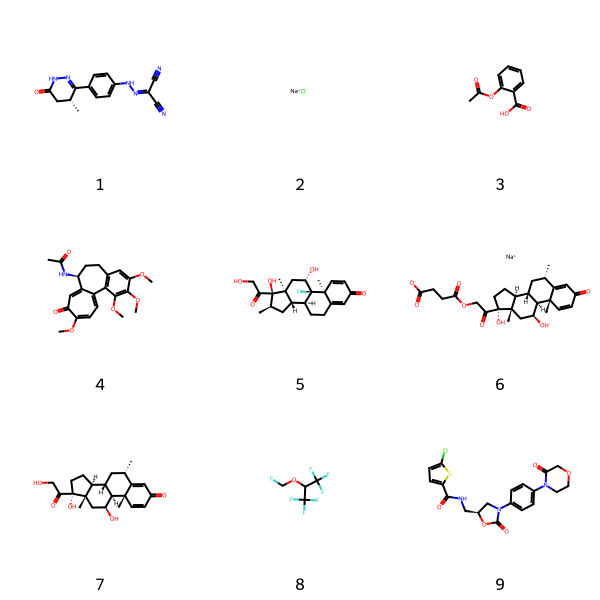

## Showing 9 example chemical structures for mesh_heading_Pain

rows=3, cols=3


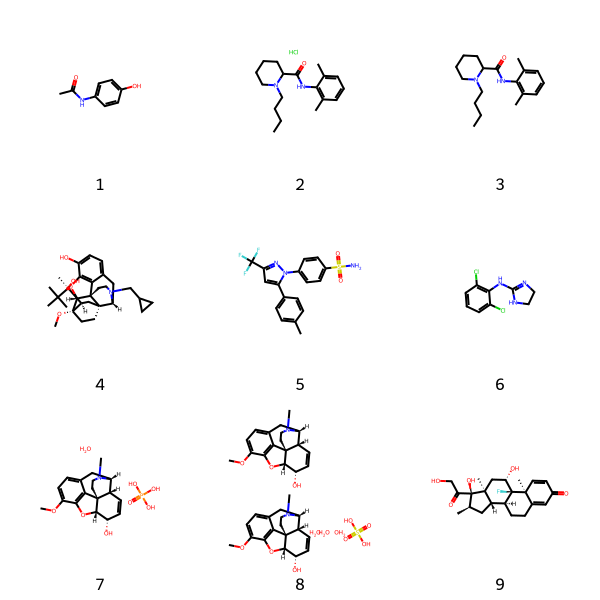

## Showing 9 example chemical structures for mesh_heading_Infections

rows=3, cols=3


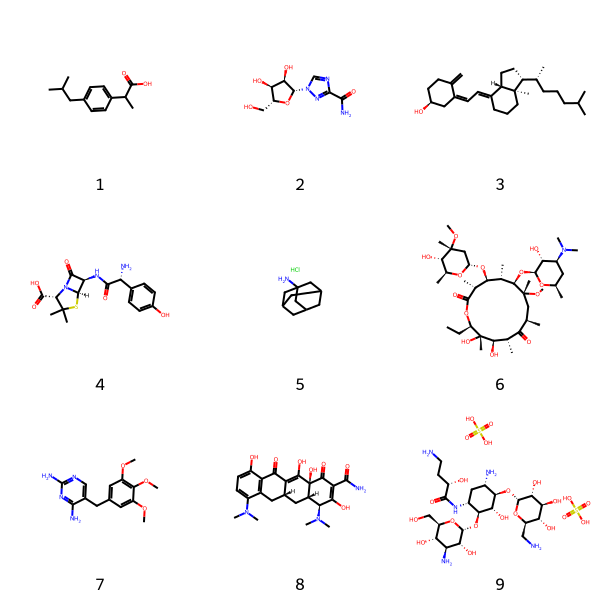

## Showing 9 example chemical structures for mesh_heading_Bacterial Infections

rows=3, cols=3


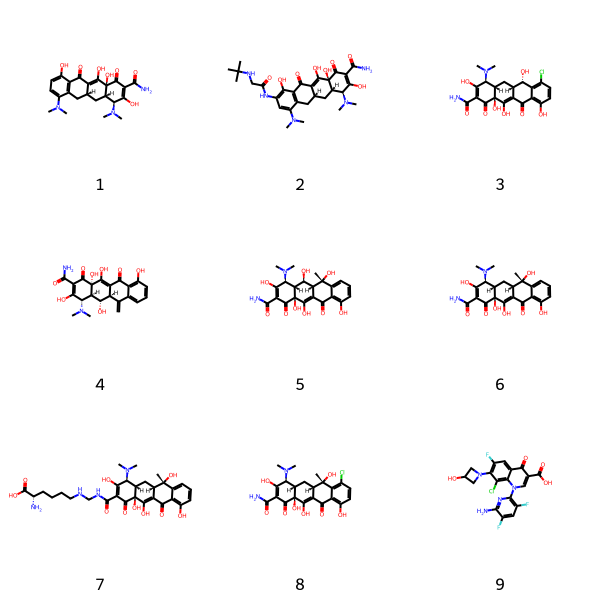

## Showing 9 example chemical structures for mesh_heading_Schizophrenia

rows=3, cols=3


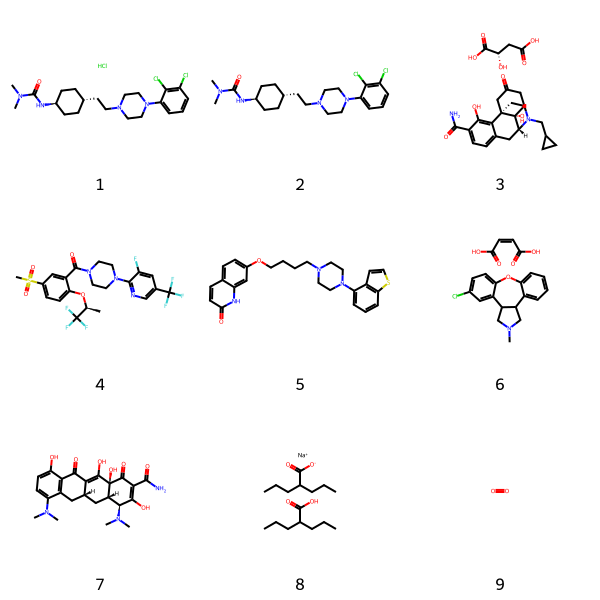

In [7]:
images_per_indication = 9  # Visualise a 3x3 grid of drug molecules

for indications_filter_index in range(10):
    # indications_filter_index = 1
    indications_filter_name = most_frequent_indications.index[indications_filter_index]
    filtered_molecules = dataset.all_data.filter(items=["canonical_smiles", indications_filter_name])
    filtered_molecules = filtered_molecules[filtered_molecules[indications_filter_name]].drop(columns=[indications_filter_name])
    filtered_molecules = filtered_molecules.rename(columns={"canonical_smiles": indications_filter_name})

    smiles_to_draw = [smiles for smiles in filtered_molecules[indications_filter_name][:images_per_indication]]

    display(Markdown(f"## Showing {images_per_indication} example chemical structures for {indications_filter_name}"))
    display(
        utilities.draw_molecules_as_grid_from_smiles(
            canonical_smiles=smiles_to_draw, 
            names=[str(i + 1) for i in range(images_per_indication)]  # Just number them
        )
    )

# Model training

In [8]:
model = ind_generator.SmilesIndGeneratorRNN(
    vocab_size = dataset.vocab_size,
    num_indications = dataset.num_indications,
    num_hiddens = 256,
    num_layers = 5,
    learning_rate = 1e-3,
    weight_decay = 1e-5,
    output_dropout = 0.4,
    rnn_dropout = 0.4,
    state_dropout = 0.4
)

In [18]:

load_model_path = "../models/Chembl-Ind-SmilesIndGeneratorRNN-CharSMILESChEMBLIndications-2025-07-30-17-50-04.pt"

train_new = False  # Set false to load a pre-trained model
save_model = True  # If trainign a new model, do we want to save it?

if train_new:
    model_trainer = trainer.Trainer(max_epochs=128, init_random=None, clip_grads_norm=10.0)
    model_trainer.fit(model, dataset)

    if save_model:
        utilities.save_model_weights("Chembl-Ind-", model, dataset)
else: 
    model.load_state_dict(
        state_dict= torch.load(load_model_path, weights_only=True),
    )
    device="cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

/home/patrick/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [19]:
if train_new:
    losses = utilities.extract_training_losses(model_trainer.metadata)
    fig, ax = plots.plot_training_validation_loss(
        training_losses = losses['avg_train_losses'], 
        validation_losses = losses['avg_val_losses']
    )
    ax.set_yscale('log')

In [20]:

test_batch = dataset[20]

output, _ = model(test_batch[0].unsqueeze(0).to(device="cuda"), test_batch[1].unsqueeze(0).to(device="cuda"))

print(f"(Seq Len, vocab size): {test_batch[0].shape}, (Indications): {test_batch[1].shape}, (Seq Len): {test_batch[2].shape}")
print(f"Input SMILES: {''.join([dataset.idx_to_char[c] for c in test_batch[2].cpu().numpy()])}")
print(f"Prediction: {''.join([dataset.idx_to_char[c] for c in output.argmax(dim=-1).squeeze().cpu().numpy()])}")

(Seq Len, vocab size): torch.Size([66, 51]), (Indications): torch.Size([80]), (Seq Len): torch.Size([66])
Input SMILES: COC(=O)C1=C(COCCN)NC(C)=C(C(=O)OC)C1c1ccccc1Cl.O=S(=O)(O)c1ccccc1£
Prediction: ssI444l-2cI42IlB485N727Ic444KKl-cI#ZIIl4sss44484I#2I2l-clc1cIIIIsb


# Lets generate some  Medications

In [11]:
rows, cols = 3, 3

n_chars = 100

n_valid = 0
n_invalid = 0
images = []
outputs = []

# Get the indices for the (rows * cols) most common drug indications
mesh_indices = [dataset.indications_names.index(indication_name) for indication_name in most_frequent_indications_names[:rows * cols]]

# We don't always get valid output, so we use a robust generation procedure to allow us to make a few
# Attempts at getting a valid output
max_attempts = 5
for idx in mesh_indices:

    output = ind_generator.robust_generate(
        ind_generator.simple_generate,
        max_attempts=max_attempts,
        prefix="",
        indications_tensor = dataset.get_indications_tensor(dataset.indications_names[idx]).to("cuda"),
        num_chars=500,
        model=model,
        char_to_idx_mapping=dataset.char_to_idx,
        idx_to_char_mapping=dataset.idx_to_char,
        temperature=0.7,
        device="cuda"

    )

    # Throw a warning if this exact output is in the training set
    if output in dataset.all_data["canonical_smiles"].tolist():
        print("\n WARNING: Exact output found in training, overfitting? \n")

    if output:
        outputs.append(output)
        n_valid += 1
    if not output:
        n_invalid += 1
        print("Generated SMILES is not valid.")
        outputs.append(None)

[17:45:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 13
[17:45:10] SMILES Parse Error: extra open parentheses while parsing: C(CCC1(C(=O)O)c1cccc(O)c1.Cl
[17:45:10] SMILES Parse Error: check for mistakes around position 2:
[17:45:10] C(CCC1(C(=O)O)c1cccc(O)c1.Cl
[17:45:10] ~^
[17:45:10] SMILES Parse Error: Failed parsing SMILES 'C(CCC1(C(=O)O)c1cccc(O)c1.Cl' for input: 'C(CCC1(C(=O)O)c1cccc(O)c1.Cl'


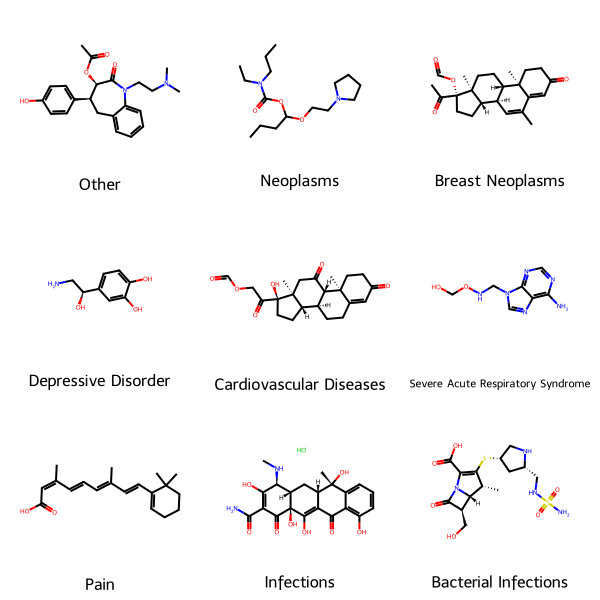

In [ ]:
display(Markdown(f"## Showing {images_per_indication} example chemical structures for {indications_filter_name}"))
display(
    utilities.draw_molecules_as_grid_from_smiles(
        canonical_smiles=outputs, 
        names=[dataset.indications_names[mesh_indices[i]].replace("mesh_heading_", "") for i in range(len(outputs))]  # Just number them
    )
)

## Sanity check... "mesh heading other" should generate essentially random molecules

In [13]:
rows, cols = 3, 3

n_chars = 100

n_valid = 0
n_invalid = 0
images = []
outputs = []

# Get the indices for the (rows * cols) "other" category
mesh_indices = [dataset.indications_names.index(most_frequent_indications_names[4])] * 9

# We don't always get valid output, so we use a robust generation procedure to allow us to make a few
# Attempts at getting a valid output
max_attempts = 5
for idx in mesh_indices:

    output = ind_generator.robust_generate(
        ind_generator.simple_generate,
        max_attempts=max_attempts,
        prefix="",
        indications_tensor = dataset.get_indications_tensor(dataset.indications_names[idx]).to(model_trainer.device),
        num_chars=500,
        model=model,
        char_to_idx_mapping=dataset.char_to_idx,
        idx_to_char_mapping=dataset.idx_to_char,
        temperature=0.7,
        device=model_trainer.device
    )

    # Throw a warning if this exact output is in the training set
    if output in dataset.all_data["canonical_smiles"].tolist():
        print("\n WARNING: Exact output found in training, overfitting? \n")

    if output:
        outputs.append(output)
        n_valid += 1
    if not output:
        n_invalid += 1
        print("Generated SMILES is not valid.")
        outputs.append(None)

[17:45:31] SMILES Parse Error: unclosed ring for input: 'Oc1ccc(CCCCC2CNC(=O)NCc2ccc(Cl)cc2)cc1.O=C(O)/C=C\C(=O)O'


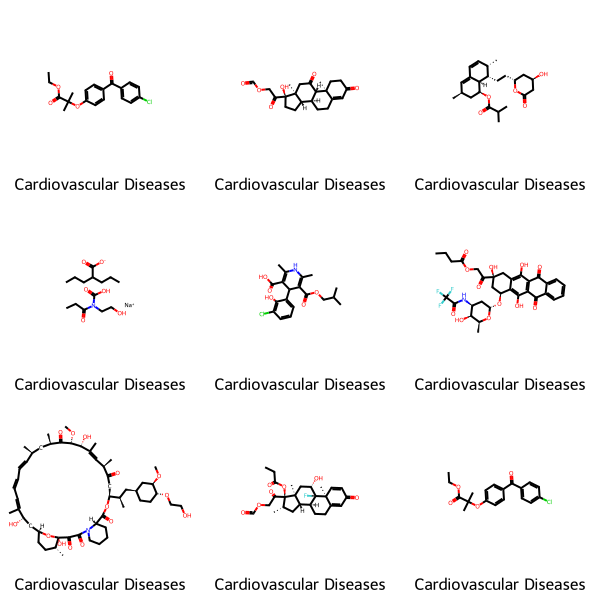

In [ ]:
display(Markdown(f"## Showing {images_per_indication} example chemical structures for {indications_filter_name}"))
display(
    utilities.draw_molecules_as_grid_from_smiles(
        canonical_smiles=outputs, 
        names=[dataset.indications_names[mesh_indices[i]].replace("mesh_heading_", "") for i in range(len(outputs))]  # Just number them
    )
)

In [131]:
rows, cols = 3, 3

n_chars = 100

n_valid = 0
n_invalid = 0
images = []
outputs = []

# Get the indices for the (rows * cols) "other" category
mesh_indices = [dataset.indications_names.index(most_frequent_indications_names[8])] * 9

# We don't always get valid output, so we use a robust generation procedure to allow us to make a few
# Attempts at getting a valid output
max_attempts = 5
for idx in mesh_indices:

    output = ind_generator.robust_generate(
        ind_generator.simple_generate,
        max_attempts=max_attempts,
        prefix="",
        indications_tensor = dataset.get_indications_tensor(dataset.indications_names[idx]).to(model_trainer.device),
        num_chars=500,
        model=model,
        char_to_idx_mapping=dataset.char_to_idx,
        idx_to_char_mapping=dataset.idx_to_char,
        temperature=0.7,
        device=model_trainer.device
    )

    # Throw a warning if this exact output is in the training set
    if output in dataset.all_data["canonical_smiles"].tolist():
        print("\n WARNING: Exact output found in training, overfitting? \n")

    if output:
        outputs.append(output)
        n_valid += 1
    if not output:
        n_invalid += 1
        print("Generated SMILES is not valid.")
        outputs.append(None)

[18:31:03] SMILES Parse Error: unclosed ring for input: 'N[C@H]1CC[C@@H](C(=O)NCCCCCCCCCCC(=O)NCCCO)C(=O)N1CCCC[C@@H](N)C(=O)N[C@@H](C)C(=O)N1C(C(=O)O)CCC[C@@H](C)C(=O)O'
[18:31:03] SMILES Parse Error: extra close parentheses while parsing: C(=O)N[C@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccc(OC)cc1)C(=O)N[C@H](CO)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N1)C(=O)NCC(N)=O
[18:31:03] SMILES Parse Error: check for mistakes around position 114:
[18:31:03] @@H](CC(N)=O)C(=O)N1)C(=O)NCC(N)=O
[18:31:03] ~~~~~~~~~~~~~~~~~~~~^
[18:31:03] SMILES Parse Error: Failed parsing SMILES 'C(=O)N[C@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccc(OC)cc1)C(=O)N[C@H](CO)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N1)C(=O)NCC(N)=O' for input: 'C(=O)N[C@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccc(OC)cc1)C(=O)N[C@H](CO)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N1)C(=O)NCC(N)=O'
[18:31:03] SMILES Parse Error: unclosed ring for input: '[C@@H](OC[C@H]1c2ccc(O)c(O)c2)C(=O)N2C(=O)N1CCC[C@H]1C(=O)O'
[18:31:03] SMILES Parse Error: syntax e

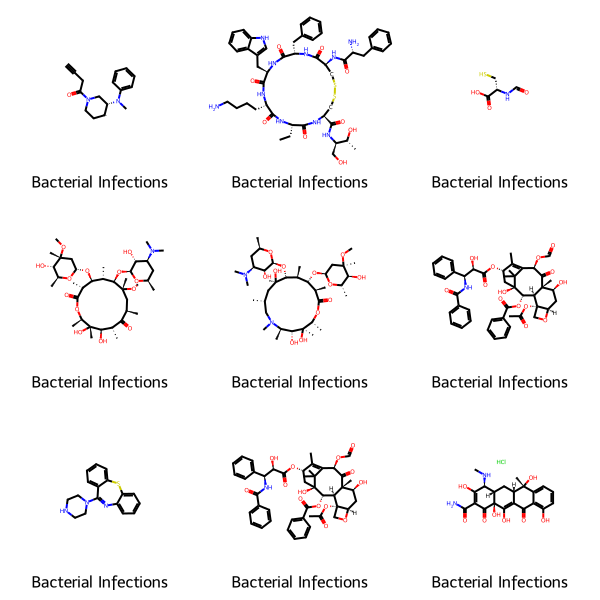

In [ ]:
display(Markdown(f"## Showing {images_per_indication} example chemical structures for {indications_filter_name}"))
display(
    utilities.draw_molecules_as_grid_from_smiles(
        canonical_smiles=outputs, 
        names=[dataset.indications_names[mesh_indices[i]].replace("mesh_heading_", "") for i in range(len(outputs))]  # Just number them
    )
)

In [ ]:
# # Fun outputs:

# Insane triple macrocycle
#  'N[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H]2C(=O)N[C@H]3C(=O)N[C@H](C(=O)N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O',

# Amino acid macrocycle, containing cysteine disulfide bridge
# 'C(C)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H](NC(=O)[C@H](N)Cc2ccccc2)CSSC[C@@H](C(=O)N[C@H](CO)[C@@H](C)O)NC1=O',

# Prompt to Generate variants of macrocycles: 
#  C[C@H]1OC(=O)[C@H](C)[C@@H](O


In [ ]:
# mol = Chem.MolFromSmiles('N[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H]2C(=O)N[C@H]3C(=O)N[C@H](C(=O)N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O')



In [100]:
visualise_3d_molecule_from_smiles(outputs[3])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.